### Libraries and Data loading

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

higgs_data = pd.read_csv("HIGGS_8K_cleaned.csv", header=None)
print("Dataset dimensions:", higgs_data.shape)
higgs_data.head()

Dataset dimensions: (8001, 29)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.0,1.630428,0.404143,0.401026,2.722409,0.355644,1.362199,0.015818,-1.174111,0.000000,...,0.387635,1.596321,1.550981,0.859235,0.827233,0.995416,0.764766,0.520597,0.850413,0.929865
2,1.0,0.326305,-0.797735,0.223471,1.248234,-1.427857,0.923767,-0.278280,-0.470052,0.000000,...,-0.426866,1.153501,0.000000,0.887944,0.924601,0.987189,0.854094,0.385013,0.789912,0.724627
3,1.0,1.381170,0.521993,0.574698,0.357347,0.037136,0.413057,-0.607036,-1.308270,0.000000,...,0.567525,-1.475778,0.000000,0.936186,1.107217,0.983808,0.693327,0.562045,0.825387,0.846233
4,1.0,0.304161,-0.736375,0.686225,0.477172,-1.274736,0.907003,0.324770,-0.463954,2.173076,...,0.904818,1.165154,0.000000,1.181790,1.033701,0.993943,0.648399,0.936097,0.732592,0.661779


### Feature separation and target

In [3]:
features_all = higgs_data.iloc[:, 1:]  # All features
features_low = higgs_data.iloc[:, 1:22]  # Low-level features
features_high = higgs_data.iloc[:, 22:]  # High-level features
target = higgs_data[0]  # Target variable

print(f"Features: All={features_all.shape[1]}, Low={features_low.shape[1]}, High={features_high.shape[1]}")

Features: All=28, Low=21, High=7


### Separating to train-test sets

In [4]:
from sklearn.model_selection import train_test_split

def create_splits(features, target):
    return train_test_split(features, target, test_size=0.25, random_state=42)

# Create splits for all datasets
X_train, X_test, y_train, y_test = create_splits(features_all, target)
Xl_train, Xl_test, _, _ = create_splits(features_low, target)
Xh_train, Xh_test, _, _ = create_splits(features_high, target)

### Data normalization

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalization for each dataset separately
scaler_all = StandardScaler().fit(X_train)
X_train_scaled = scaler_all.transform(X_train)
X_test_scaled = scaler_all.transform(X_test)

scaler_low = StandardScaler().fit(Xl_train)
Xl_train_scaled = scaler_low.transform(Xl_train)
Xl_test_scaled = scaler_low.transform(Xl_test)

scaler_high = StandardScaler().fit(Xh_train)
Xh_train_scaled = scaler_high.transform(Xh_train)
Xh_test_scaled = scaler_high.transform(Xh_test)

print("Normalization completed!")

Normalization completed!


### KNN with GridSearchCV

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Search parameters
knn_params = {
    'n_neighbors': range(1, 30, 2),  # More small neighbor values
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create models
knn_all = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
knn_low = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)
knn_high = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, n_jobs=-1)

### Model training

In [7]:
print("Training model with all features...")
knn_all.fit(X_train_scaled, y_train)

print("Training model with low-level features...")
knn_low.fit(Xl_train_scaled, y_train)

print("Training model with high-level features...")
knn_high.fit(Xh_train_scaled, y_train)

Training model with all features...


Training model with low-level features...
Training model with high-level features...


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': range(1, 30, 2), 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,27


### Results

In [8]:
results = {
    'Dataset': ['All', 'Low', 'High'],
    'Best Accuracy': [
        knn_all.best_score_,
        knn_low.best_score_,
        knn_high.best_score_
    ],
    'Best Params': [
        str(knn_all.best_params_),
        str(knn_low.best_params_),
        str(knn_high.best_params_)
    ]
}

pd.DataFrame(results).style.set_properties(**{'text-align': 'left'})

,Dataset,Best Accuracy,Best Params
0,All,0.639833,"{'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}"
1,Low,0.583667,"{'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}"
2,High,0.686333,"{'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}"


### Prediction and Confusion matrix

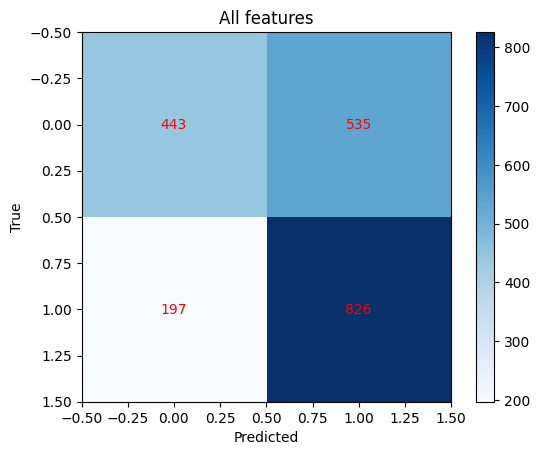

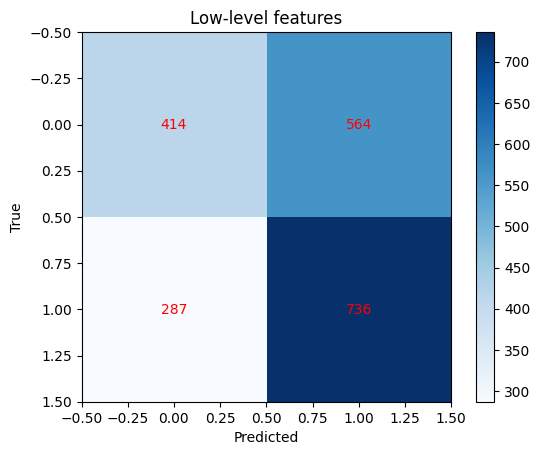

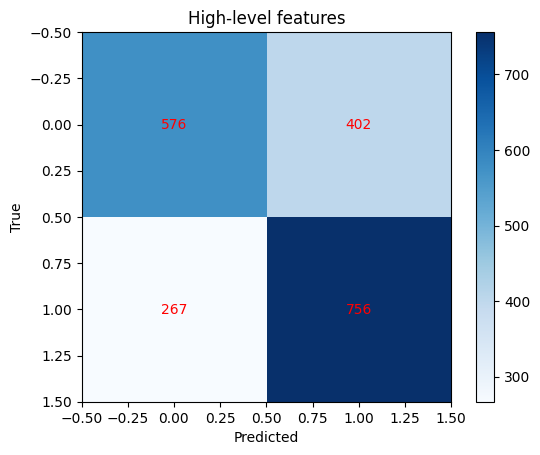

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
    plt.show()

plot_confusion(y_test, knn_all.predict(X_test_scaled), 'All features')
plot_confusion(y_test, knn_low.predict(Xl_test_scaled), 'Low-level features')
plot_confusion(y_test, knn_high.predict(Xh_test_scaled), 'High-level features')

### Classification accuracy

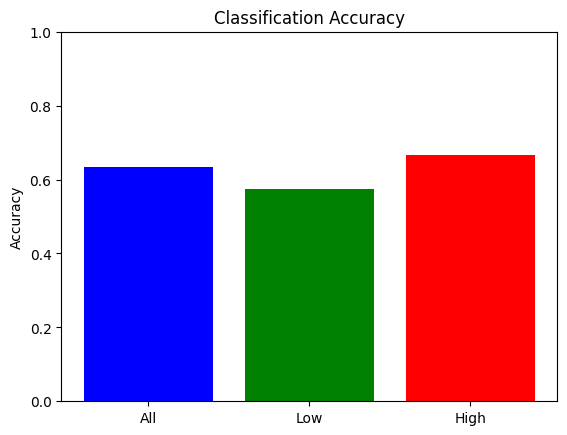

In [14]:
from sklearn.metrics import accuracy_score

acc_all = accuracy_score(y_test, knn_all.predict(X_test_scaled))
acc_low = accuracy_score(y_test, knn_low.predict(Xl_test_scaled))
acc_high = accuracy_score(y_test, knn_high.predict(Xh_test_scaled))

plt.bar(['All', 'Low', 'High'], [acc_all, acc_low, acc_high], color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.ylim(0, 1)
plt.show()

### ROC Curve

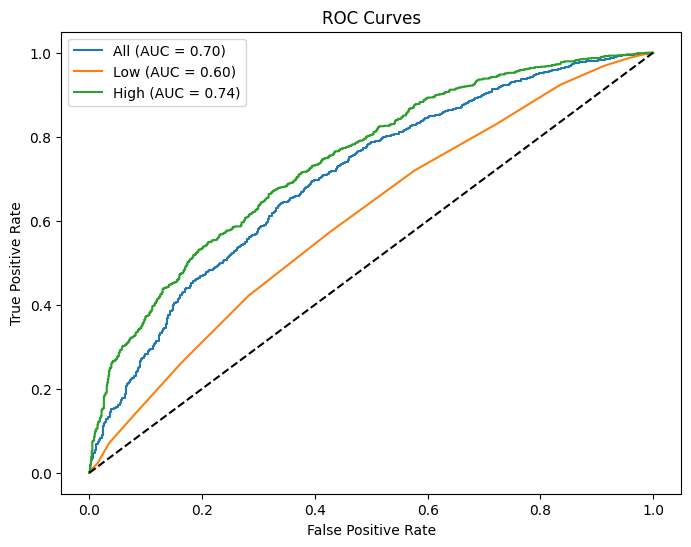

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8,6))
plot_roc(y_test, knn_all.predict_proba(X_test_scaled)[:,1], 'All')
plot_roc(y_test, knn_low.predict_proba(Xl_test_scaled)[:,1], 'Low')
plot_roc(y_test, knn_high.predict_proba(Xh_test_scaled)[:,1], 'High')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### AUC Scores

In [16]:
from sklearn.metrics import roc_auc_score

auc_scores = {
    'Dataset': ['All', 'Low', 'High'],
    'AUC Score': [
        roc_auc_score(y_test, knn_all.predict_proba(X_test_scaled)[:,1]),
        roc_auc_score(y_test, knn_low.predict_proba(Xl_test_scaled)[:,1]),
        roc_auc_score(y_test, knn_high.predict_proba(Xh_test_scaled)[:,1])
    ]
}

pd.DataFrame(auc_scores).style.hide(axis='index').background_gradient(cmap='Blues')

Dataset,AUC Score
All,0.701439
Low,0.603205
High,0.742364
